# Using the CrossRCW module

In this notebook, we demonstrate the `CrossRCW` model, which implements rigorous coupled wave (RCW) analysis for cross gratings. First, import the modules we will need:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pySCATMECH.crossrcw import *

We will use a cross grating consisting of a square grid of cylindrical holes to demonstrate the use of the module. We set up the grating below and feed it to the RCW solver.  I have a file named "fusedsilica" that contains the index of refraction of fused silica as a function of wavelength.

In [2]:
period = 0.5
order = 5
theta = 70

gratingParameters = {
    None : 'Cylinder_CrossGrating',
              'medium_i' : 1,
              'medium_t' : "fusedsilica",
              'zeta' : 0,
              'd1' : period,
              'd2' : period,
              'grid1' : 256,
              'grid2' : 256,
              'rtop' : 0.1,
              'rbottom' : 0.1,
              'thickness' : 0.1,
              'nlevels' : 1,
              'inside' : 1,
              'outside' : "fusedsilica"}

rcwParameters = {
    'thetai' : theta,
    'rotation' : 0,
    'lambda' : 0.532,
    'type' : '0',
    'order1' : order,
    'order2' : order,
    'grating' : gratingParameters
    }

model = CrossRCW_Model(rcwParameters)


Let's show the NCS parameters (NCS refering to the unique elements of the non-depolarizing Mueller matrix: 01, 22, and 23) for the 0th order diffraction (specular) as a function of wavelength:

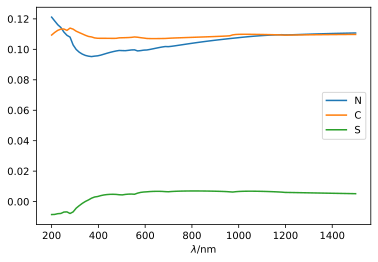

In [3]:
wavelengths = np.linspace(0.2, 1.5, 100)

def rcw(wavelength):
    model.setParameter('lambda',wavelength)
    return model.DiffractionEfficiency(0,0)

muellerMatrices = [rcw(wavelength) for wavelength in wavelengths]

N = [m[0,1] for m in muellerMatrices]
C = [m[2,2] for m in muellerMatrices]
S = [m[2,3] for m in muellerMatrices]

plt.figure()
plt.plot(wavelengths*1000, N, label="N")
plt.plot(wavelengths*1000, C, label="C")
plt.plot(wavelengths*1000, S, label="S")
plt.xlabel('$\lambda$/nm')
plt.legend()
plt.show()

Let's do the same thing, but rotate the sample 22.5 degrees. The Mueller matrices are no longer block diagonal.

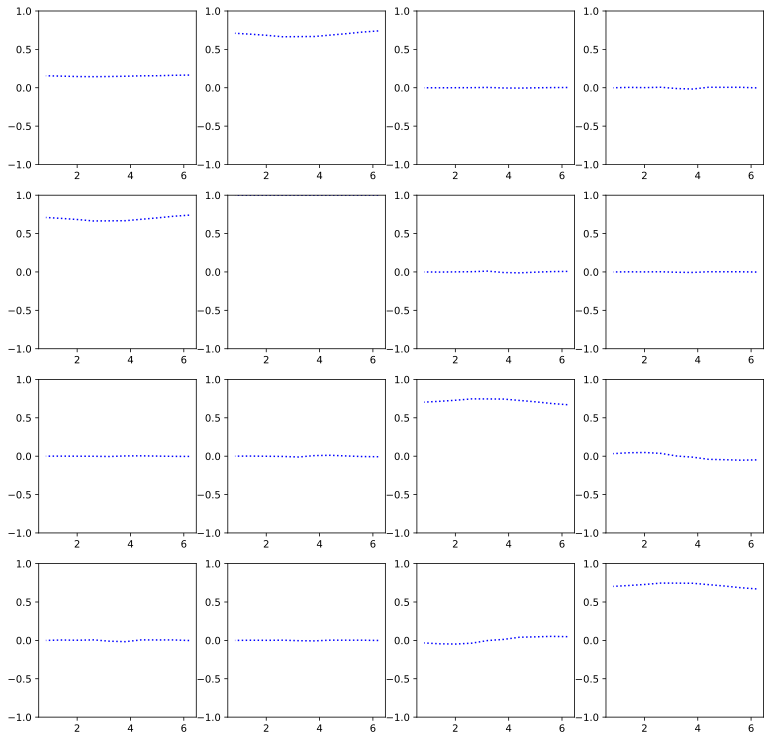

In [4]:
um2eV = 1.239841775 
energies = np.linspace(um2eV/0.2,um2eV/1.5,10)

rcwParameters['rotation'] = 22.5

def rcwA(energy):
    rcwParameters["lambda"] = um2eV/energy
    model.setParameters(rcwParameters)
    m = model.DiffractionEfficiency(0,0)
    m, m[0,0] = m/m[0,0],m[0,0] # Normalize the matrix, keeping the m[0,0] element
    return m

muellerMatrices = [rcwA(E) for E in energies]

plt.figure(figsize = [13,13])
for element in range(16):
    plt.subplot(4,4,element+1)
    plt.ylim(-1,1)
    plt.plot(energies,[muellerMatrices[i][element//4,element%4] for i in range(len(energies))],'b:')

plt.show()

Finally, let's visualize the diffraction pattern from a hexagonal grating having a large period.

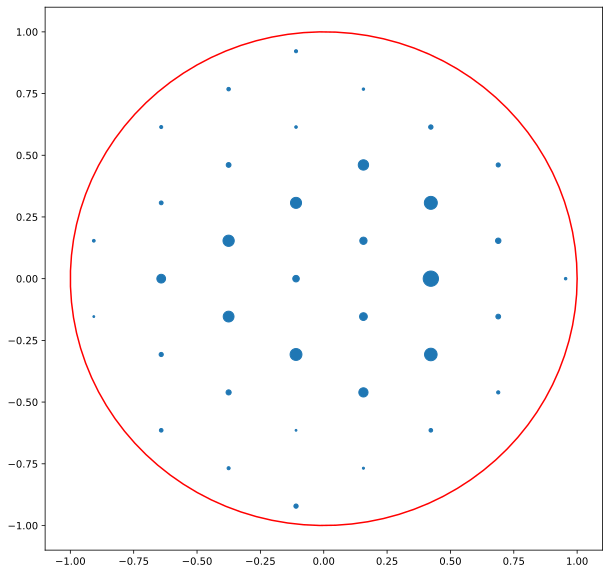

In [5]:
period = 2
order = 10
theta = 25

gratingParameters = {
    None : 'Cylinder_CrossGrating',
              'medium_i' : 1, 
              'medium_t' : 1, # Free standing
              'zeta' : 30,    # Hexagonal pattern
              'd1' : period,
              'd2' : period,
              'grid1' : 256,
              'grid2' : 256,
              'rtop' : period/4,
              'rbottom' : period/4,
              'thickness' : 100, # Very deep
              'nlevels' : 1,
              'inside' : 1,     # Holes in
              'outside' : 1.5   # glass
            }

rcwParameters = {
    'thetai' : theta,
    'rotation' : 0,
    'lambda' : 0.532,
    'type' :   1,  # in transmission
    'order1' : order,
    'order2' : order,
    'grating' : gratingParameters
    }

model.setParameters(rcwParameters)

def plotDiffractionPattern(model):
    order1 = int(model.getParameter("order1"))
    order2 = int(model.getParameter("order2"))
    x, y, I = [], [], []
    for i in range(-order1,order1):
        for j in range(-order2,order2):
            # Direction() function gets the direction 
            direction = model.Direction(i,j) 
            if direction[2] != 0 :
                x.append(direction[0])
                y.append(direction[1])
                I.append(model.DiffractionEfficiency(i,j)[0,0])
       
    thetas = np.linspace(0, 2*pi, 100)
    circlex = np.cos(thetas)
    circley = np.sin(thetas)
    
    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    ax.scatter(x, y, s=np.array(I)*2000) # You may need to adjust this size scaling
    ax.plot(circlex, circley, c = 'r')
    plt.show()

plotDiffractionPattern(model)